In [15]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, StepLR, SequentialLR
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer

from core.multimodal.dataset2 import VPSMDatasetV2
from core.multimodal.model import ModelV1

from core.data.utils import preprocess_spectra, readLRSFits, preprocess_lc, get_vlc, add_noise, aug_metadata

# from core.metadata.model import MetaClassifier
# from models.Informer import Informer

In [3]:
CLASSES = ['EW', 'SR', 'EA', 'RRAB', 'EB', 'ROT', 'RRC', 'HADS', 'M', 'DSCT']
METADATA_COLS = [
    'mean_vmag', 'amplitude', 'period', 'phot_g_mean_mag', 'e_phot_g_mean_mag', 'lksl_statistic',
    'rfr_score', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe'
]

In [4]:
def get_config(random_seed):
    config = {
        'project': 'AstroCLIP',     # 'AstroCLIP', 'AstroCLIPResults'
        'training_mode': 'clip',      # 'clip', 'classification'
        'model': 'ModelV1',  # 'ModelV0' or 'ModelV1'
        'random_seed': random_seed,
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        # 'use_pretrain': '/home/mariia/AstroML/weights/2024-07-25-14-18-es6hl0nb/weights-41.pth',
        'use_pretrain': None,
        'freeze': False,
        'fusion': 'avg',    # 'avg', 'concat'

        # Data General
        'dataset': 'VPSMDatasetV2',     # 'VPSMDataset' or 'VPSMDatasetV2'
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'preprocessed_data/full/spectra_and_v',
        'classes': CLASSES,
        'min_samples': None,
        'max_samples': None,
        'noise': False,  # for train data only
        'noise_coef': 2,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': True,
        'clip': False,
        'aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        'spectra_v_file': 'spectra_v_merged.csv',
        'z_corr': False,

        # Photometry Model
        'p_encoder_layers': 8,
        'p_d_model': 128,
        'p_dropout': 0.2,
        'p_feature_size': 3,
        'p_n_heads': 4,
        'p_d_ff': 512,

        # Spectra Model
        's_hidden_dim': 512,
        's_dropout': 0.2,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0.2,

        # MultiModal Model
        'hidden_dim': 1024,
        'ps_coef': 1,
        'mp_coef': 1,
        'sm_coef': 1,

        # Training
        'batch_size': 64,
        'lr': 1e-3,
        'weight_decay': 1e-3,
        'epochs': 100,
        'optimizer': 'AdamW',
        'early_stopping_patience': 10,

        # Learning Rate Scheduler
        'factor': 0.3,
        'patience': 5,
    }

    if config['aux']:
        config['p_feature_size'] += 4

    return config

In [5]:
config = get_config(42)

In [5]:
train1 = VPSMDatasetV2(
    split='train', data_root=config['data_root'], file=config['file'], v_zip=config['v_zip'],
    v_prefix=config['v_prefix'], lamost_spec_dir=config['lamost_spec_dir'], min_samples=config['min_samples'],
    max_samples=config['max_samples'], classes=config['classes'], seq_len=config['seq_len'],
    phased=config['phased'], clip=config['clip'], aux=config['aux'], z_corr=config['z_corr'],
    random_seed=config['random_seed'], noise=config['noise'], noise_coef=config['noise_coef'],
)
val1 = VPSMDatasetV2(
    split='val', data_root=config['data_root'], file=config['file'], v_zip=config['v_zip'],
    v_prefix=config['v_prefix'], lamost_spec_dir=config['lamost_spec_dir'], min_samples=config['min_samples'],
    max_samples=config['max_samples'], classes=config['classes'], seq_len=config['seq_len'],
    phased=config['phased'], clip=config['clip'], aux=config['aux'], z_corr=config['z_corr'],
    random_seed=config['random_seed'], noise=False,
)

In [7]:
config['meta_cols'] = METADATA_COLS
config['mode'] = 'all'

In [7]:
train2 = PSMDataset(config, split='train')
val2 = PSMDataset(config, split='val')

In [8]:
len(train1) == len(train2), len(val1) == len(val2)

(True, True)

In [9]:
idx = 100
photometry1, photometry_mask1, spectra1, metadata1, label1 = val1[idx]
photometry2, photometry_mask2, spectra2, metadata2, label2 = val2[idx]

In [10]:
np.array_equal(photometry1, photometry2)

True

In [11]:
np.array_equal(photometry_mask1, photometry_mask2)

True

In [12]:
np.array_equal(spectra1, spectra2)

True

In [13]:
np.array_equal(metadata1, metadata2)

True

In [14]:
np.array_equal(label1, label2)

True

In [15]:
old_model = ModelV1(config)

In [16]:
old_model.spectra_encoder

GalSpecNet(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (mp1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (mp2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (mp3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
config['num_classes'] = 10
config['s_use_classification'] = True
config['s_conv_channels'] = [1, 64, 64, 32, 32]
config['s_kernel_size'] = 3
config['s_mp_kernel_size'] = 4

In [10]:
s_model = GalSpecNet(config)

In [11]:
s_model

GalSpecNet(
  (layers): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (10): ReLU()
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [20]:
config['m_use_classification'] = True

In [21]:
m_model = MetaModel(config)

In [22]:
m_model

MetaModel(
  (model): Sequential(
    (0): Linear(in_features=36, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
old_model.metadata_encoder

MetaModel(
  (model): Sequential(
    (0): Linear(in_features=36, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [28]:
config['p_enc_in'] = 7    # feature size
config['p_d_model'] = 128
config['p_dropout'] = 0.2
config['p_factor'] = 1
config['p_output_attention'] = False
config['p_n_heads'] = 4
config['p_d_ff'] = 512
config['p_activation'] = 'gelu'
config['p_e_layers'] = 8

In [6]:
p_model = Informer(config)

KeyError: 'mode'

In [33]:
str(p_model) == str(old_model.photometry_encoder)

True

In [76]:
optimizer = Adam(s_model.parameters(), lr=1e-4)
scheduler1 = StepLR(optimizer, step_size=1, gamma=2)
scheduler2 = ExponentialLR(optimizer, gamma=0.9)
scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[5])

In [79]:
lrs = []

for i in range(30):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])

    if i == 4:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-3

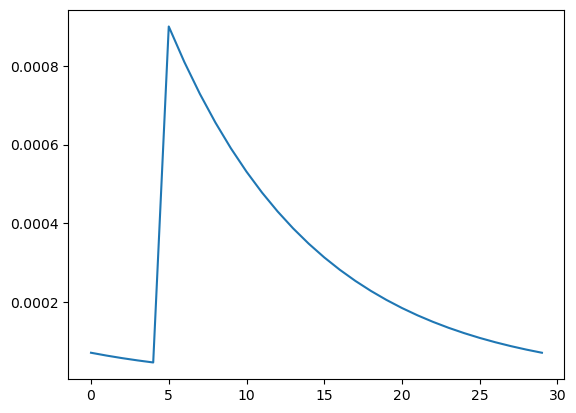

In [80]:
plt.plot(lrs)

In [ ]:
scheduler1 = ConstantLR(optimizer, factor=0.1, total_iters=2)
scheduler2 = ExponentialLR(optimizer, gamma=0.9)
scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[2])

for epoch in range(100):
    scheduler.step()